# **Analyzing Feminism Discourse on Reddit Using Natural Language Processing**

## Step 1: Environment Setup & Dependencies

This section loads all the required libraries, organized by function:

- **General-Purpose**
  - `os`, `re`, `string`, `ast`: used for file handling, regular expressions, text cleaning, and parsing string-encoded data.
  - `pandas`, `numpy`: for data manipulation and analysis.

- **Visualization**
  - `matplotlib.pyplot`, `seaborn`: for plotting and data visualization.
  - `WordCloud`: to generate word clouds from text data.

- **Text Processing**
  - `CountVectorizer`, `ENGLISH_STOP_WORDS`: tools from `sklearn` for feature extraction and stopword filtering.

- **Transformers & Sentiment Analysis**
  - Hugging Face’s `transformers`, `torch`, and `softmax`: for sentiment classification using pretrained transformer models.

- **Topic Modeling**
  - `BERTopic`: for extracting and visualizing topics from text.
  - `SentenceTransformer`: for generating document embeddings needed by BERTopic.

- **Progress Monitoring**
  - `tqdm`: provides progress bars to track loops and long operations.

In [140]:
# General-Purpose Libraries
import os
import re
import string
import ast
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# Transformers & Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.nn.functional import softmax

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Progress Monitoring
from tqdm import tqdm

## Step 2: Load the Dataset

The dataset was scraped using the Reddit API (via PRAW) and contains posts and comments related to feminism.  

This step reads the CSV file into a pandas DataFrame for further analysis.

In [121]:
# Load the dataset of Reddit posts and comments
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"
filename = "feminism_praw_posts_comments.csv"
file_path = os.path.join(base_path, filename)

print("Loading dataset from:", file_path)
df = pd.read_csv(file_path)
print(f"Dataset loaded successfully. Number of entries: {len(df)}")

Loading dataset from: C:/Users/asmae/Documents/GitHub/Feminism\feminism_praw_posts_comments.csv
Dataset loaded successfully. Number of entries: 959


## Step 3: Parse, Normalize, and Flatten Reddit Comments

This step consolidates the parsing and restructuring of the `comments` column, which contains string-encoded lists of Reddit comments.

It includes the following sub-steps:

1. **Safe Parsing**: Convert string-encoded lists into actual Python lists using a custom parsing function.
2. **Normalization**: Treat each individual comment as a standalone textual entry.
3. **Metadata Retention**: Link each comment back to its parent post (e.g., `post_id`, `title`, `subreddit`) for context-aware analysis.
4. **Export**: Save the flattened comments into a new CSV file for modular analysis.

In [100]:
# Convert 'comments' column to proper lists
df["comments"] = df["comments"].apply(safe_parse_comments)

# Flatten comments into a new DataFrame
comments_data = []
for i, row in df.iterrows():
    for comment in row["comments"]:
        if isinstance(comment, str) and comment.strip():  # Skip empty strings
            comments_data.append({
                "parent_post_id": row["id"],
                "text": comment,
                "source": "comment",
                "subreddit": row["subreddit"],
                "keyword": row["keyword"],
                "post_title": row["title"]
            })

comments_df = pd.DataFrame(comments_data)

# Save flattened comments as a new CSV file
comments_output = os.path.join(base_path, "feminism_comments_as_posts.csv")
comments_df.to_csv(comments_output, index=False)

print(f"Flattened and saved {len(comments_df)} individual comments to: {comments_output}")

Flattened and saved 18468 individual comments to: C:/Users/asmae/Documents/GitHub/Feminism\feminism_comments_as_posts.csv


## Step 4: Identify and Visualize Top Subreddits

This step analyzes which subreddits most frequently post about feminism, based on the 900 posts in the dataset.

We:
1. Count the number of posts per subreddit.
2. Identify the top 10 most active subreddits.
3. Visualize the results in a horizontal bar chart for quick comparison.

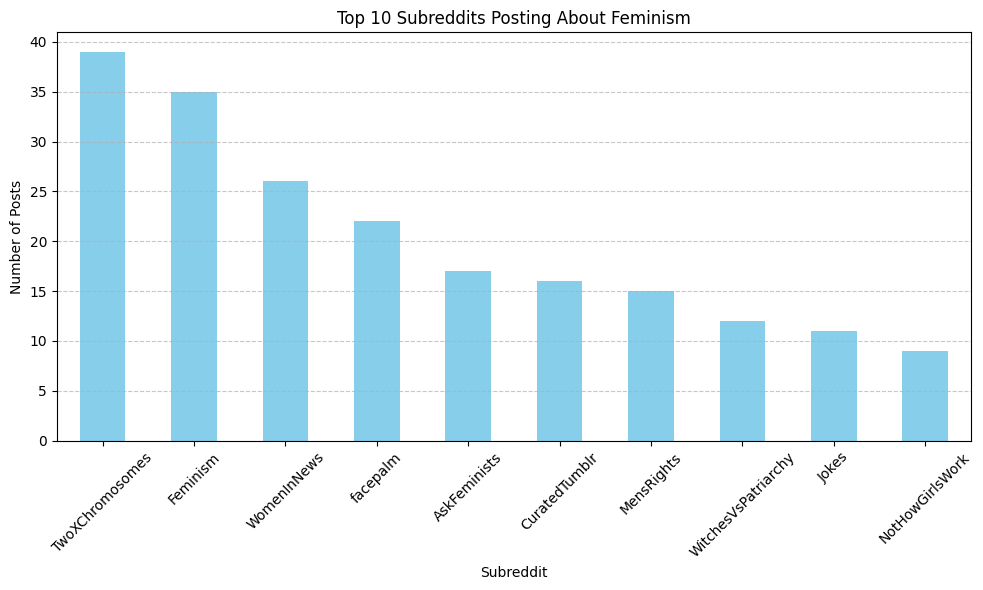

In [101]:
# Count the number of posts per subreddit
subreddit_counts = df['subreddit'].value_counts().head(10)

# Plot the top 10 subreddits
plt.figure(figsize=(10, 6))
subreddit_counts.plot(kind='bar', color='skyblue')
plt.title('Top 10 Subreddits Posting About Feminism')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Step 5: Manual Topic Tagging Using In-Dataset Keywords

To ensure that topics reflect actual discourse in the data, this step uses **predefined categories** and **only keywords that occur in the dataset**.

Each Reddit post is assigned a topic label based on keyword presence in the cleaned content. This rule-based approach helps create interpretable, focused topic classifications for downstream analysis.

Topics include:
- Feminism in Pop Culture
- Feminist Politics and Law
- Accusations of Hypocrisy in Feminism
- Sexual Violence 
- Trans and Gender Inclusion
- Gender Roles and Relationships
- Intersectional Feminism
- Social Norms and Community

In [122]:
# Create 'content' field if needed
if "content" not in df.columns and "title" in df.columns and "selftext" in df.columns:
    df["content"] = df["title"].fillna("") + " " + df["selftext"].fillna("")

# === Clean the text ===
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www.\S+", "", text)             # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)                    # Remove punctuation and digits
    text = re.sub(r"\s+", " ", text)                        # Normalize spaces
    return text.strip()

df['clean_content'] = df['content'].apply(preprocess)

# === Define topic keyword categories (in-dataset terms only) ===
topic_keywords = {
    "feminism_in_pop_culture": [
        'media', 'story', 'celebrity', 'pop', 'emma', 'watson',
        'beyonce', 'taylor', 'katy', 'perry', 'icon'
    ],
    "feminist_politics_and_law": [
        'patriarchy', 'political', 'campaign', 'rights', 'laws', 'trump',
        'sanders', 'equality', 'movement', 'vote'
    ],
    "performative_feminism": [
        'pseudo', 'performative', 'fake'
    ],
    "sexual_violence_and_misconduct": [
        'abuse', 'rape', 'violence', 'sexual', 'harassment', 'power',
        'help'
    ],
    "trans_and_gender_inclusion": [
        'terf', 'trans', 'gender', 'transition'
    ],
    "gender_roles_and_relationships": [
        'husband', 'wife', 'relationship', 'love', 'family', 'friends',
        'emotional', 'dating', 'marriage', 'baby', 'mother', 'father', 'age'
    ],
    "intersectional_feminism": [
        'black', 'race', 'intersectionality', 'identity', 'inclusion', 'justice'
    ],
    "social_norms_and_community": [
        'society', 'culture', 'norms', 'values', 'community', 'change'
    ]
}

# === Assign topic based on keyword match ===
def assign_topic(text):
    for topic, keywords in topic_keywords.items():
        if any(keyword in text for keyword in keywords):
            return topic
    return "other"

df['keyword_topic'] = df['clean_content'].apply(assign_topic)

# === Preview ===
print(df[['title', 'keyword_topic']].head())

# === Save labeled data ===
output_file = os.path.join(base_path, "feminism_posts_tagged_by_topic.csv")
df.to_csv(output_file, index=False)
print(f"Labeled data saved to: {output_file}")


                                               title  \
0                     "Victimized by the Patriarchy"   
1  Beyonce's pseudo-feminism is letting her keep ...   
2                                 That is a good one   
3                         I love a Ben Shapiro burn.   
4  TIL Jules Verne's wrote a novel in 1863 which ...   

                    keyword_topic  
0       feminist_politics_and_law  
1         feminism_in_pop_culture  
2                           other  
3  gender_roles_and_relationships  
4  sexual_violence_and_misconduct  
Labeled data saved to: C:/Users/asmae/Documents/GitHub/Feminism\feminism_posts_tagged_by_topic.csv


## Step 6: Visualize Topic Distribution

This step visualizes how Reddit posts are distributed across the manually defined topic categories.

A bar chart is used to display the number of posts per topic. The design emphasizes readability and clarity, suitable for academic or policy-oriented reports.

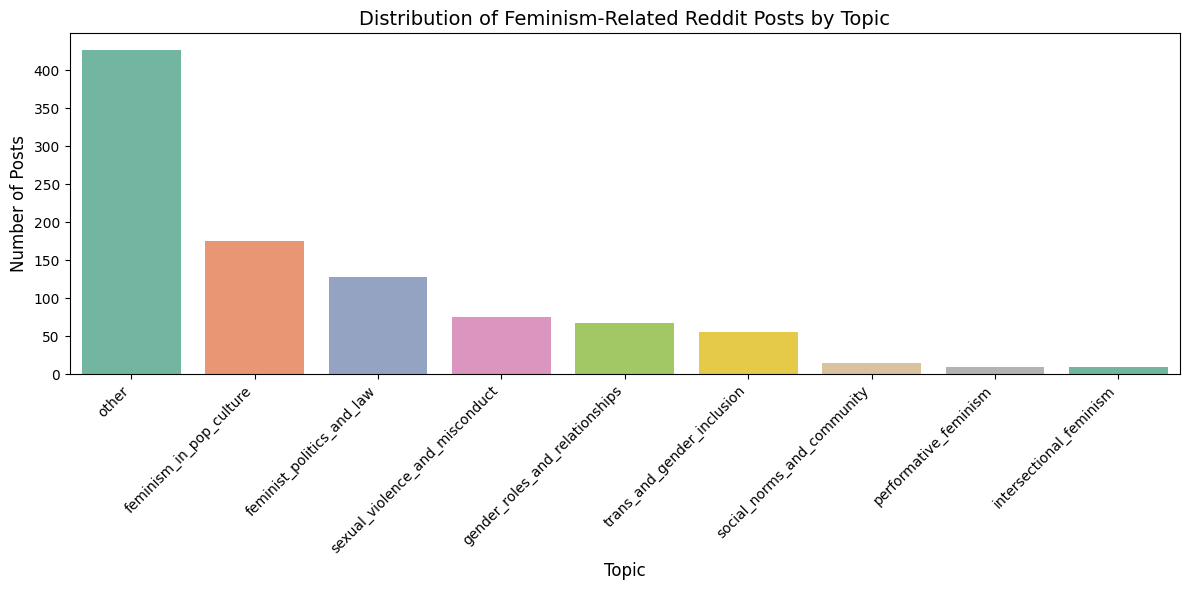

In [103]:
# Count and sort topics
topic_counts = df['keyword_topic'].value_counts().sort_values(ascending=False)

# Custom color palette
palette = sns.color_palette("Set2", len(topic_counts))

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette=palette)

# Labels and title
plt.title("Distribution of Feminism-Related Reddit Posts by Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 7: Topic-Focused Word Clouds

This step generates a word cloud for each manually defined topic.  
Rather than visualizing all words, each cloud highlights only the specific keywords associated with that topic, reflecting their frequency within the dataset.

This approach supports interpretability and emphasizes the thematic structure defined earlier.

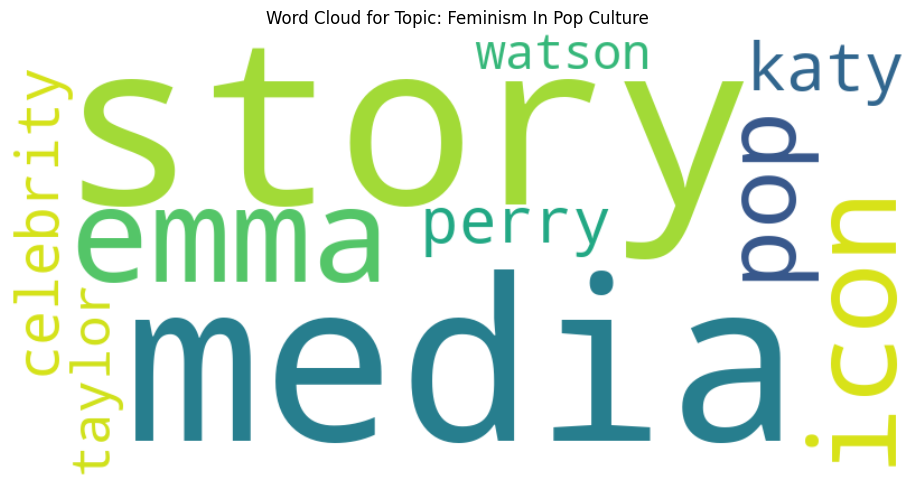

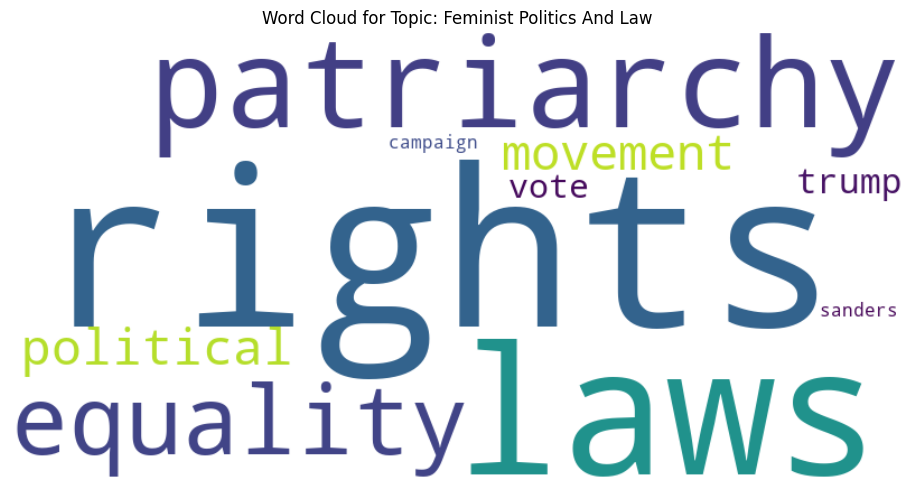

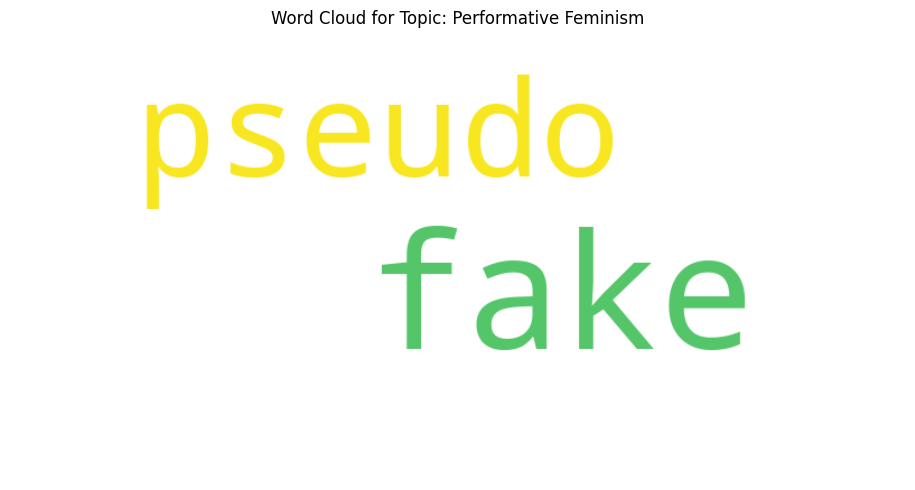

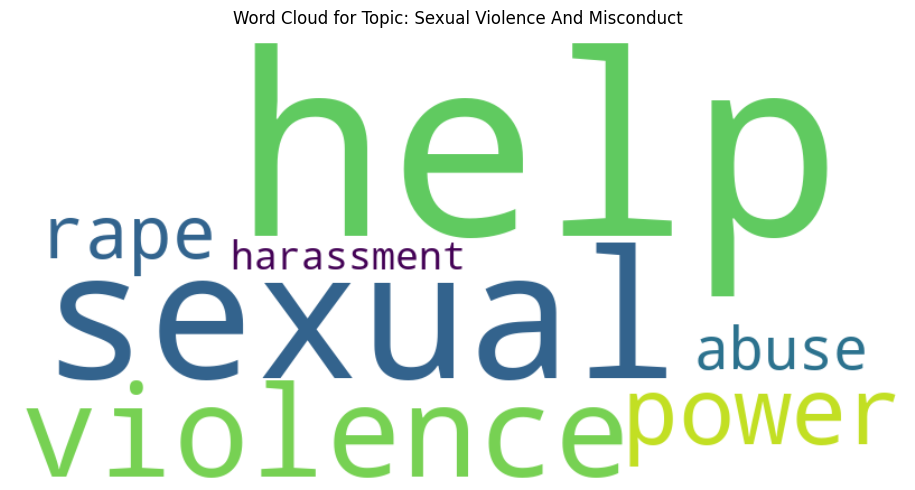

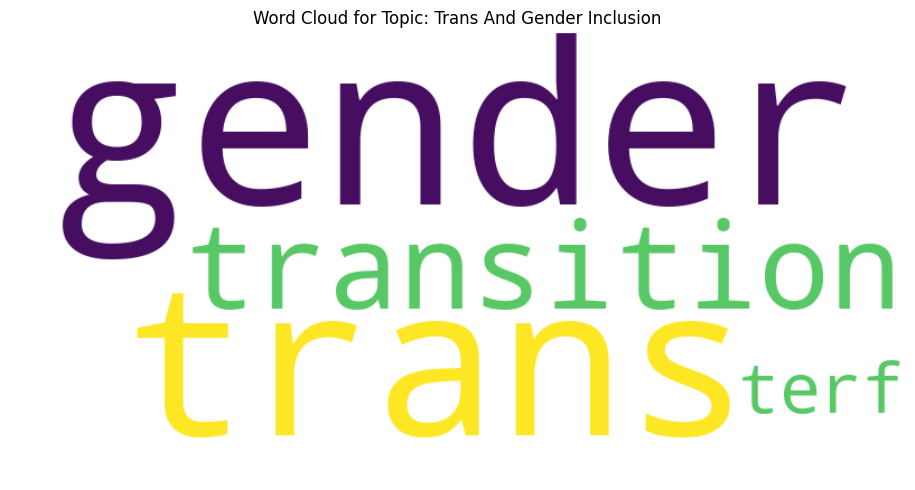

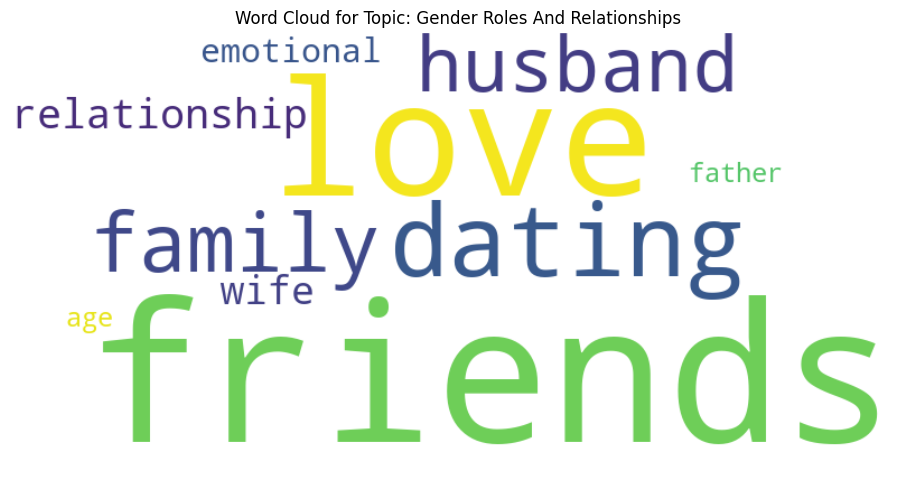

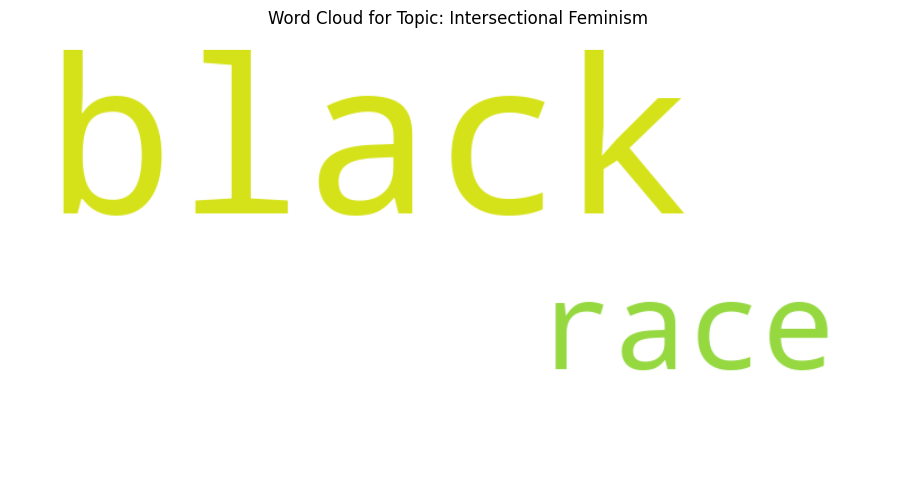

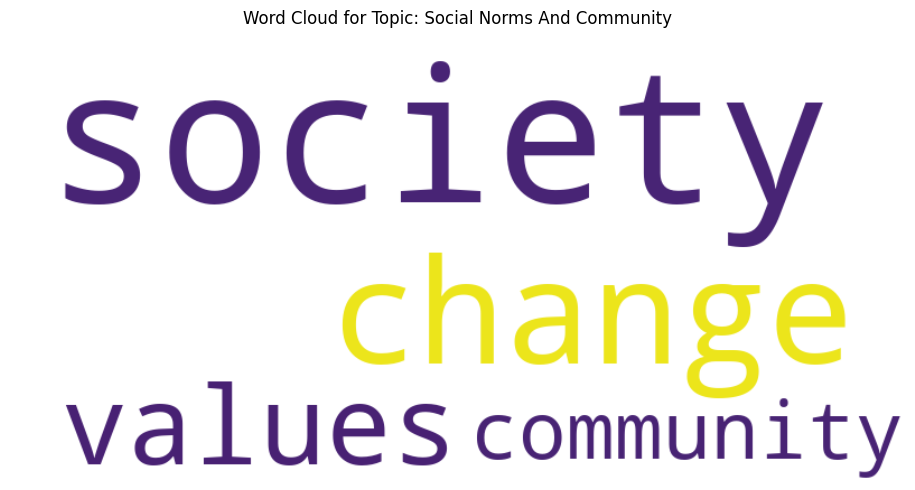

In [104]:
# Generate a word cloud per topic using only the topic's defined keywords
for topic, keywords in topic_keywords.items():
    topic_df = df[df['keyword_topic'] == topic]
    all_text = " ".join(topic_df['clean_content'])

    # Count frequency of only relevant keywords
    keyword_counts = Counter()
    for word in all_text.split():
        if word in keywords:
            keyword_counts[word] += 1

    # Skip empty topics
    if not keyword_counts:
        continue

    # Generate word cloud from top 10 keywords
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=10
    ).generate_from_frequencies(keyword_counts)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Topic: {topic.replace('_', ' ').title()}")
    plt.tight_layout()
    plt.show()


## Step 8: Sentiment Analysis Using Multilingual BERT

This step applies a pre-trained BERT model (`nlptown/bert-base-multilingual-uncased-sentiment`)  
to classify Reddit posts on a scale of 1 to 5 stars (Very Negative → Very Positive).

We:
- Combine post title and body into a single input
- Predict sentiment and extract confidence scores
- Map numerical ratings to descriptive labels
- Visualize the sentiment distribution overall and by keyword topic

In [105]:
# Load BERT model
MODEL_NAME = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Load your dataset
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"
filename = "feminism_praw_posts_comments.csv"
file_path = os.path.join(base_path, filename)
df = pd.read_csv(file_path)

# Combine title and body
df['text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

# Sentiment prediction function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)
    scores = probs.squeeze().tolist()
    stars = torch.argmax(probs, dim=1).item() + 1  # Convert to 1–5 scale
    return stars, scores

# Apply sentiment analysis
sentiments = []
confidence_scores = []

for text in tqdm(df['text'], desc="Analyzing Sentiment"):
    try:
        stars, scores = predict_sentiment(text)
    except Exception:
        stars, scores = None, [None] * 5
    sentiments.append(stars)
    confidence_scores.append(scores)

# Store results
df['bert_sentiment'] = sentiments
df[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']] = pd.DataFrame(confidence_scores)

# Save results
output_file = os.path.join(base_path, "feminism_posts_with_bert_sentiment.csv")
df.to_csv(output_file, index=False)
print("✅ Sentiment analysis complete. Results saved to:", output_file)

Analyzing Sentiment: 100%|██████████| 959/959 [06:41<00:00,  2.39it/s]


✅ Sentiment analysis complete. Results saved to: C:/Users/asmae/Documents/GitHub/Feminism\feminism_posts_with_bert_sentiment.csv


## Step 9: Sentiment Analysis and Visualization

This step presents the results of sentiment classification applied to Reddit posts discussing feminism.  
The analysis uses the `nlptown/bert-base-multilingual-uncased-sentiment` model, which assigns a sentiment rating on a 5-point scale ranging from **Very Negative (1 star)** to **Very Positive (5 stars)**.

The sentiment predictions are visualized in two ways:

### 9.1 Overall Sentiment Distribution

The first visualization is a bar plot showing the overall sentiment distribution across all posts.  
This provides a high-level overview of the emotional tone in Reddit discussions about feminism.

### 9.2 Sentiment Distribution by Topic

The second visualization breaks down sentiment by predefined topic categories (e.g., _sexual_violence_and_misconduct_, _feminism_in_pop_culture_, _gender_roles_and_relationships_).  
Each topic is represented as a stacked bar, showing the number of posts in each sentiment category.  
This allows for comparative analysis of emotional tone across different feminist discourse themes.

Together, these visualizations help identify patterns in how feminism is framed and received in different thematic contexts on Reddit.

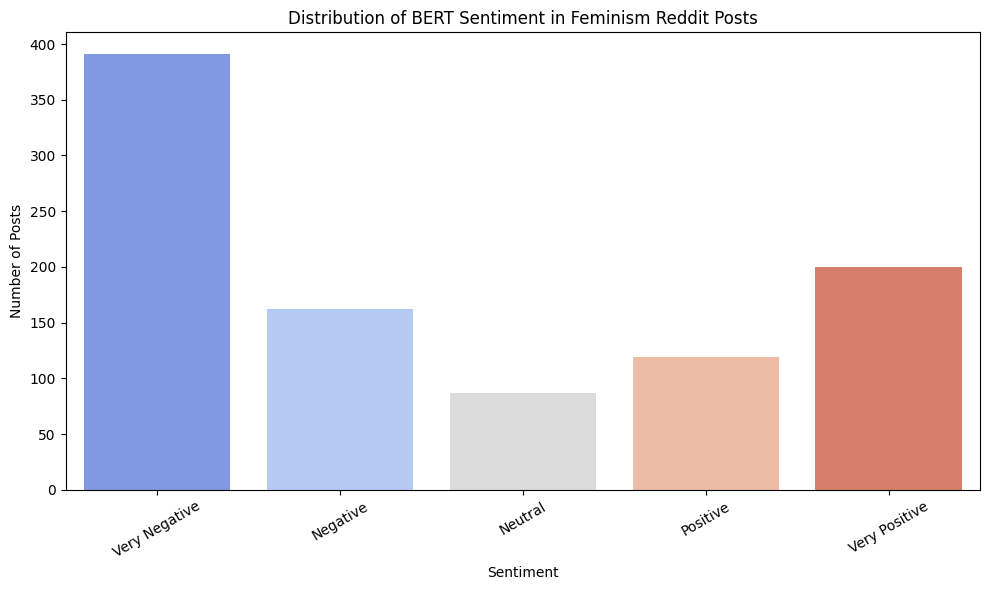

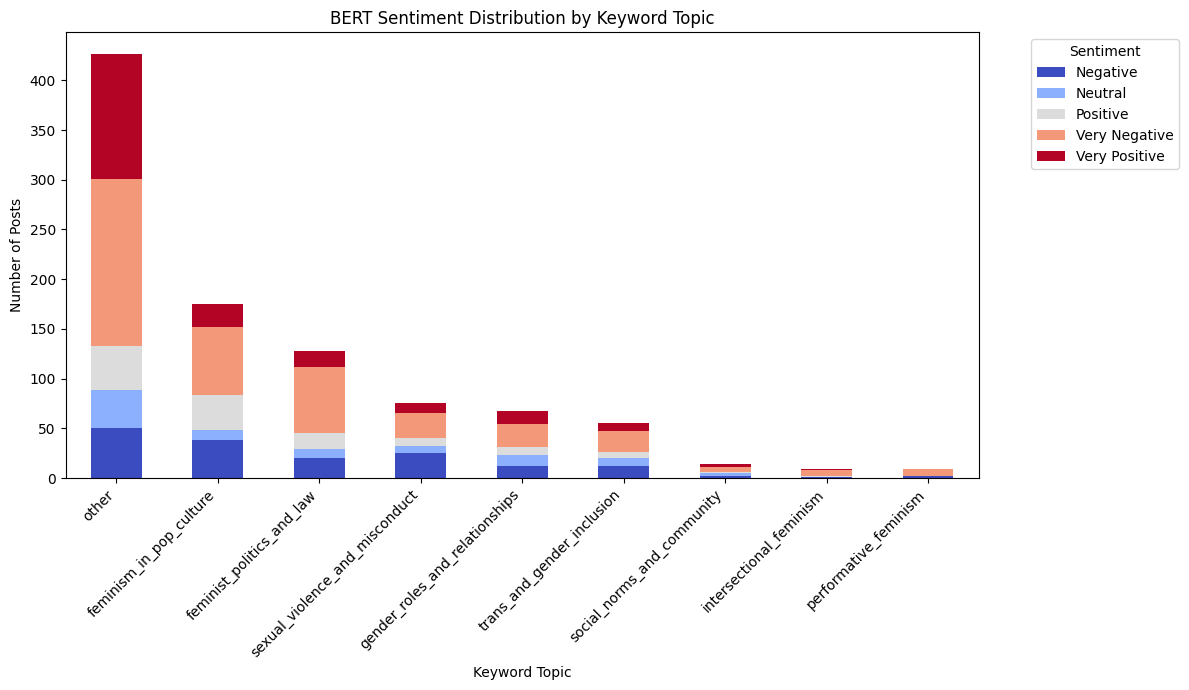

In [111]:
# Load datasets
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"

# Load CSV with topic categories
topic_file = os.path.join(base_path, "feminism_posts_tagged_by_topic.csv")
df_topics = pd.read_csv(topic_file)

# Load CSV with BERT sentiment scores
sentiment_file = os.path.join(base_path, "feminism_posts_with_bert_sentiment.csv")
df_sentiment = pd.read_csv(sentiment_file)

# Merge on unique ID 
df = pd.merge(df_topics, df_sentiment[["id", "bert_sentiment", "score_1", "score_2", "score_3", "score_4", "score_5"]],
              on="id", how="inner")

# Map numeric sentiment to descriptive labels
sentiment_labels = {
    1: "Very Negative",
    2: "Negative",
    3: "Neutral",
    4: "Positive",
    5: "Very Positive"
}
df["sentiment_label"] = df["bert_sentiment"].map(sentiment_labels)

# === Part A: Plot overall sentiment distribution ===
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="sentiment_label",
    order=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"],
    palette="coolwarm"
)
plt.title("Distribution of BERT Sentiment in Feminism Reddit Posts")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# === Part B: Sentiment by Topic ===
# Group and pivot
topic_sentiment_counts = (
    df.groupby(["keyword_topic", "sentiment_label"])
    .size()
    .reset_index(name="count")
)

pivot_df = topic_sentiment_counts.pivot(
    index="keyword_topic",
    columns="sentiment_label",
    values="count"
).fillna(0)

# Sort topics by total volume
pivot_df["total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by="total", ascending=False).drop(columns="total")

# Plot stacked bar chart
pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 7),
    colormap="coolwarm"
)
plt.title("BERT Sentiment Distribution by Keyword Topic")
plt.xlabel("Keyword Topic")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Step 10: Comment Analysis — Common Words

In this step, we analyze the most frequently used and meaningful words in Reddit comments discussing feminism. To ensure relevance, we:

- Cleaned and tokenized comment text
- Removed standard stopwords and a custom list of filler or generic verbs (e.g. like, say, know, think)
- Counted the most common remaining words
- Visualized the top 40 using a word cloud

This visualization reveals dominant themes and expressions in user-generated discourse, offering insight into how feminist topics are discussed in comment threads.


In [126]:
# === Load comments dataset ===
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"
filename = "feminism_comments_as_posts.csv"
file_path = os.path.join(base_path, filename)

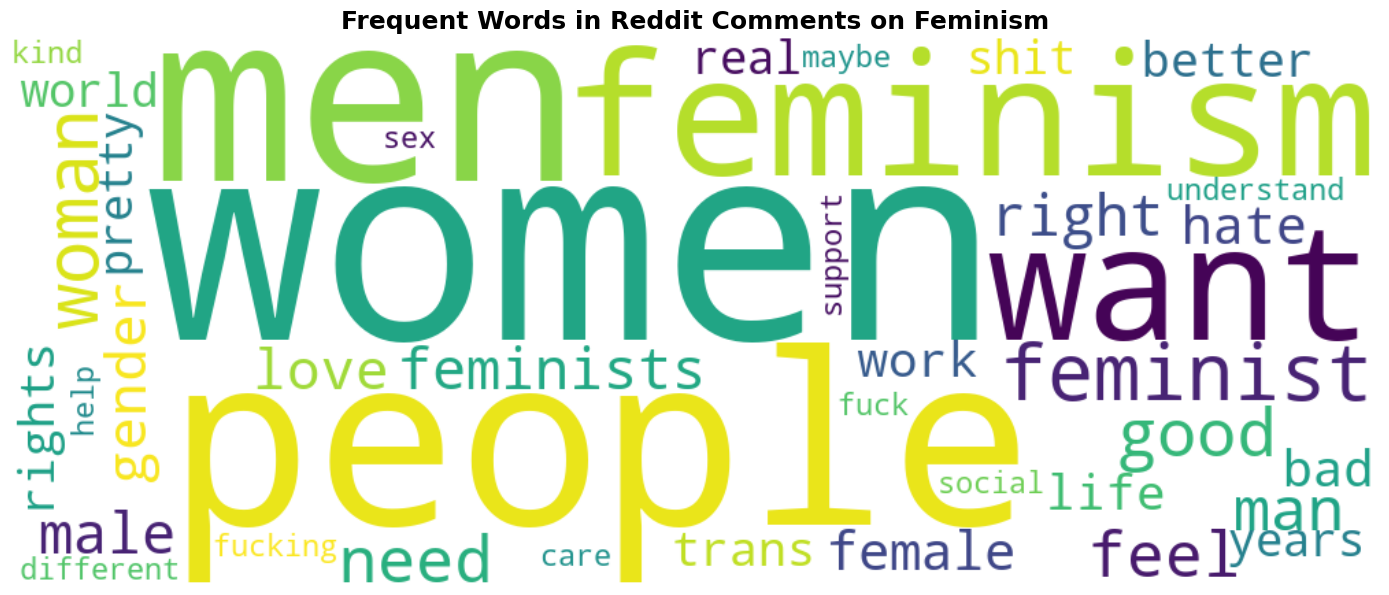

In [ ]:
# === Define stopwords and custom exclusions ===
stop_words = ENGLISH_STOP_WORDS
custom_exclude = {
    "like", "actually", "think", "say", "says", "said", "make", "makes", "made",
    "just", "things", "really", "time", "did", "going", "lot", "does", "thing",
    "know", "having", "way", "got", "getting", "believe", "post", "point", "read",
    "guy", "saying", "doing", "sure", "look", "mean", "seen", "trying", "thought",
    "person", "use", "making", "little", "literally", "tell", "long", "new", "probably"
}

# === Clean and tokenize comments ===
def clean_and_tokenize(text):
    tokens = str(text).lower().split()
    return [
        word.strip(string.punctuation)
        for word in tokens
        if word not in stop_words and word.isalpha()
    ]

comments_df["tokens"] = comments_df["text"].apply(clean_and_tokenize)

# === Count words and apply exclusions ===
all_words = [word for tokens in comments_df["tokens"] for word in tokens]
filtered_words = [
    word for word in all_words
    if word not in custom_exclude and word not in stop_words
]
top_words = Counter(filtered_words).most_common(40)
top_words_dict = dict(top_words)

# === Generate and plot word cloud ===
wordcloud = WordCloud(
    width=1000,
    height=400,
    background_color="white",
    max_words=40
).generate_from_frequencies(top_words_dict)

plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Reddit Comments on Feminism", fontsize=18, weight="bold")
plt.tight_layout()
plt.show()


## Step 11: Keyword Frequency in Reddit Comments

This step explores how often key feminist-related terms appear in Reddit comments. We:

- Converted all comment text to lowercase for consistent keyword matching
- Defined a list of indicative terms spanning gender, rights, violence, and ideology
- Counted each keyword’s frequency across all comments
- Visualized the top terms using a horizontal bar chart

This analysis helps identify which feminist-related concepts dominate the discussion and highlights recurring topics such as gender identity, sexual violence, and political polarization.

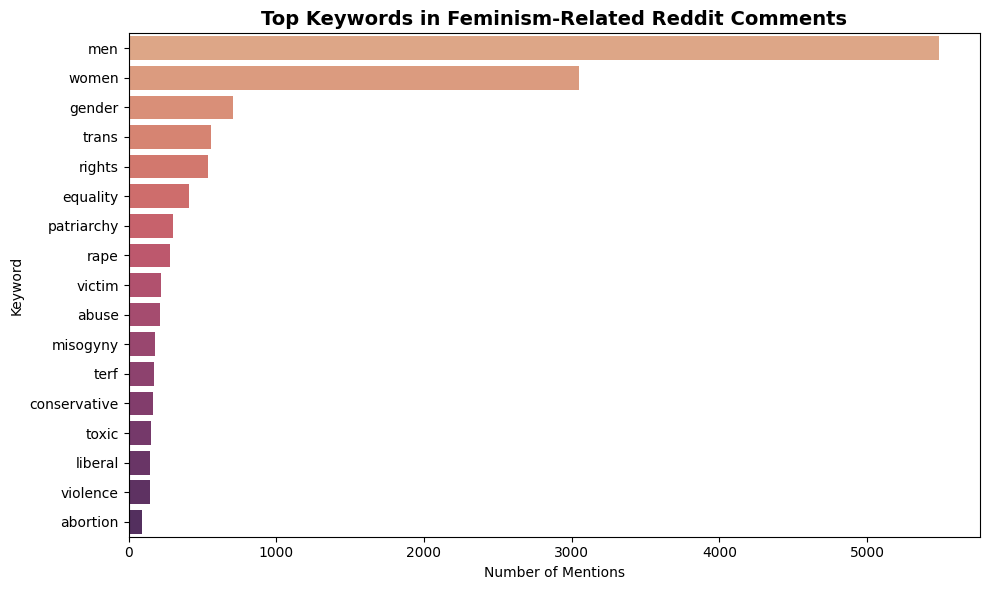

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the dataset
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"
filename = "feminism_comments_as_posts.csv"
file_path = os.path.join(base_path, filename)
df = pd.read_csv(file_path)

# Standardize text to lowercase for consistent keyword matching
df["text_lower"] = df["text"].astype(str).str.lower()

# Define a list of indicative feminist-related keywords
keywords = [
    "men", "women", "gender", "trans", "rights", "equality", "patriarchy",
    "rape", "victim", "abuse", "misogyny", "terf", "conservative",
    "toxic", "liberal", "violence", "abortion"
]

# Count keyword occurrences across all comments
keyword_counts = {kw: df["text_lower"].str.contains(kw).sum() for kw in keywords}
sorted_keywords = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the keyword frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_keywords.values()), y=list(sorted_keywords.keys()), palette="flare")
plt.title("Top Keywords in Feminism-Related Reddit Comments", fontsize=14, weight="bold")
plt.xlabel("Number of Mentions")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

## BERT Sentiment Analysis on Reddit Comments

We applied BERT-based sentiment analysis to the comments using the cardiffnlp/twitter-roberta-base-sentiment model. The original model provides probabilities for three sentiment classes: Negative, Neutral, and Positive. To enable a more granular interpretation, we mapped these probabilities onto a five-point sentiment scale:

- Very Negative
- Negative
- Neutral
- Positive
- Very Positive

This mapping was based on thresholding the softmax scores:

- positive > 0.7 → Very Positive
- positive > 0.5 → Positive
- neutral > 0.5 → Neutral
- negative > 0.5 → Negative
- Remaining cases → Very Negative

Each comment was classified into one of these five categories, and the final distribution was visualized using a bar chart.

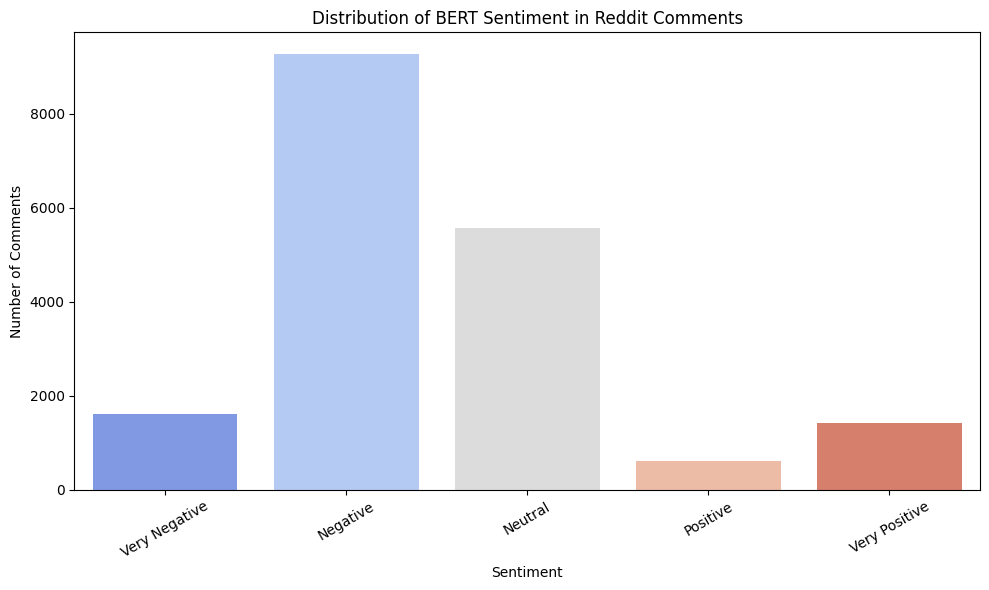

In [139]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

# === Load comment dataset ===
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"
filename = "feminism_comments_as_posts.csv"
file_path = os.path.join(base_path, filename)
df = pd.read_csv(file_path)

# === Load BERT model ===
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# === Define sentiment classification function ===
def classify_comment(text):
    text = str(text).replace('\n', ' ').replace('\r', ' ')
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits[0].numpy())
    labels = ['negative', 'neutral', 'positive']
    score_dict = dict(zip(labels, scores))
    
    # Convert 3-class score to 5-point sentiment
    if score_dict['positive'] > 0.7:
        sentiment = 5
    elif score_dict['positive'] > 0.5:
        sentiment = 4
    elif score_dict['neutral'] > 0.5:
        sentiment = 3
    elif score_dict['negative'] > 0.5:
        sentiment = 2
    else:
        sentiment = 1

    return sentiment, score_dict['negative'], score_dict['neutral'], score_dict['positive']

# === Apply to all comments ===
df[['bert_sentiment', 'score_1', 'score_3', 'score_5']] = df['text'].apply(
    lambda x: pd.Series(classify_comment(x))
)

# === Map sentiment labels ===
sentiment_labels = {
    1: "Very Negative",
    2: "Negative",
    3: "Neutral",
    4: "Positive",
    5: "Very Positive"
}
df["sentiment_label"] = df["bert_sentiment"].map(sentiment_labels)

# === Save with sentiment results (optional) ===
output_file = os.path.join(base_path, "feminism_comments_with_bert_sentiment.csv")
df.to_csv(output_file, index=False)

# === Plot overall sentiment distribution ===
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x="sentiment_label",
    order=["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"],
    palette="coolwarm"
)
plt.title("Distribution of BERT Sentiment in Reddit Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## Comparative Analysis of r/Feminism and r/MensRights

We analyzed top posts from r/Feminism and r/MensRights, focusing on three dimensions:

- Sentiment: Using the cardiffnlp/twitter-roberta-base-sentiment model to measure post polarity from negative to positive.
- Toxicity: Using unitary/toxic-bert to score harmful or offensive language.
- Linguistic Divergence: Using TF-IDF vectors and cosine distance to measure how lexically distinct the two subreddits are.

The Polarization Index combines: *absolute difference in average sentiment*, *absolute difference in toxicity* and *lexical divergence*.

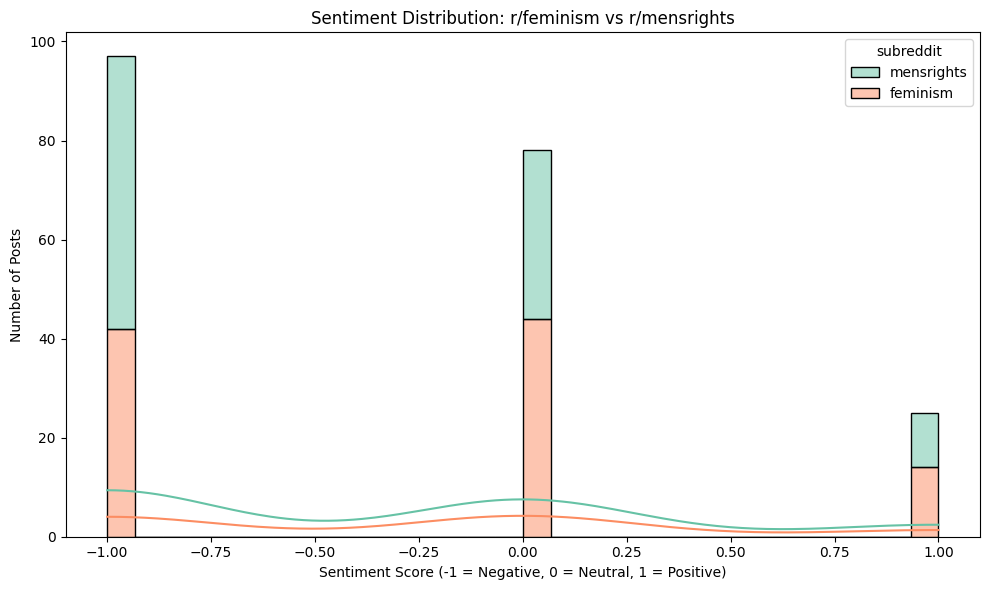

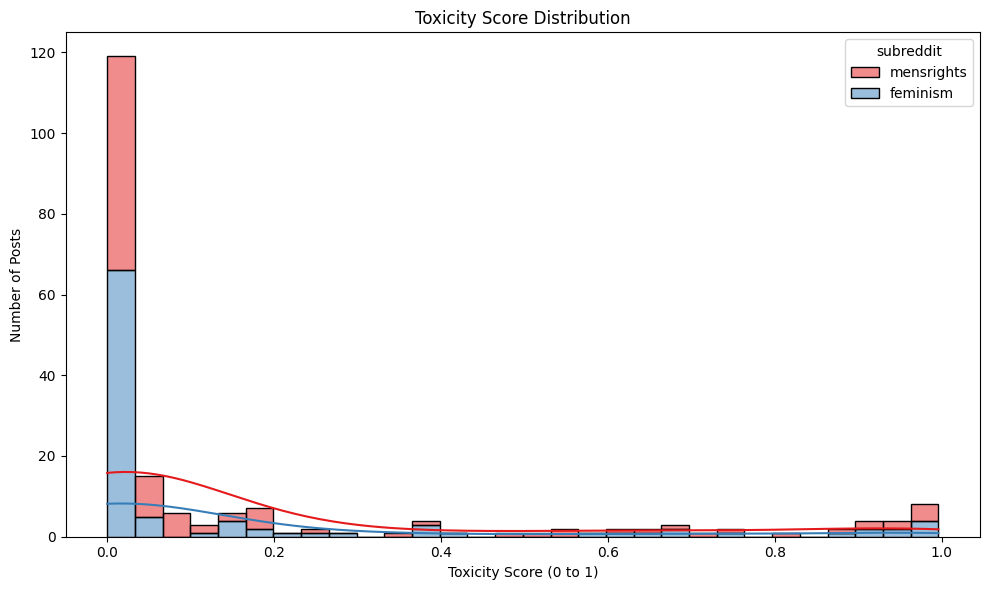

Polarization Summary
    subreddit  sentiment_numeric  toxicity  linguistic_divergence  \
0    Feminism              -0.28     0.164                  0.688   
1  MensRights              -0.44     0.186                  0.688   

   polarization_index  
0                0.87  
1                0.87  


In [ ]:
# === Load pre-saved datasets ===
base_path = "C:/Users/asmae/Documents/GitHub/Feminism"

posts_file = f"{base_path}/reddit_feminism_polarization_posts.csv"
summary_file = f"{base_path}/polarization_index_summary.csv"

df = pd.read_csv(posts_file)
group_stats = pd.read_csv(summary_file)

# === Clean subreddit names ===
df['subreddit'] = df['subreddit'].str.lower()

# === Visualize sentiment distribution ===
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="sentiment_numeric", hue="subreddit", kde=True, bins=30, palette="Set2", multiple="stack")
plt.title("Sentiment Distribution: r/feminism vs r/mensrights")
plt.xlabel("Sentiment Score (-1 = Negative, 0 = Neutral, 1 = Positive)")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

# === Visualize toxicity distribution ===
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="toxicity", hue="subreddit", kde=True, bins=30, palette="Set1", multiple="stack")
plt.title("Toxicity Score Distribution")
plt.xlabel("Toxicity Score (0 to 1)")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

# === Print summary table ===
print("Polarization Summary")
print(group_stats.round(3))
